In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

In [2]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# # sample
# idx = np.random.choice(np.arange(len(trainset)), size=10000)
# trainset = [trainset[i] for i in idx]
# idx = np.random.choice(np.arange(len(testset)), size=10000)
# testset = [testset[i] for i in idx]

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [3]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

len(train_dataset), len(test_dataset)

(60000, 10000)

In [57]:
model = Encoder().cuda()
model.load_state_dict(torch.load("./data/pretrain_results/DR_weights.pt"))
model.eval()

Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=2, bias=True)
)

In [58]:
Z_train = []
for data, label in train_loader:
    z = model(data.cuda()).view(-1,2)
    Z_train.append(z)

Z_train = torch.vstack(Z_train)
Z_train.shape

torch.Size([60000, 2])

In [59]:
Z_test = []
for data, label in test_loader:
    z = model(data.cuda()).view(-1,2)
    Z_test.append(z)

Z_test = torch.vstack(Z_test)
Z_test.shape

torch.Size([10000, 2])

In [60]:
torch.save(Z_train.detach().cpu(), "./data/Z_train_pretrainDR_60k.pt")

In [61]:
torch.save(Z_test.detach().cpu(), "./data/Z_test_pretrainDR_60k.pt")

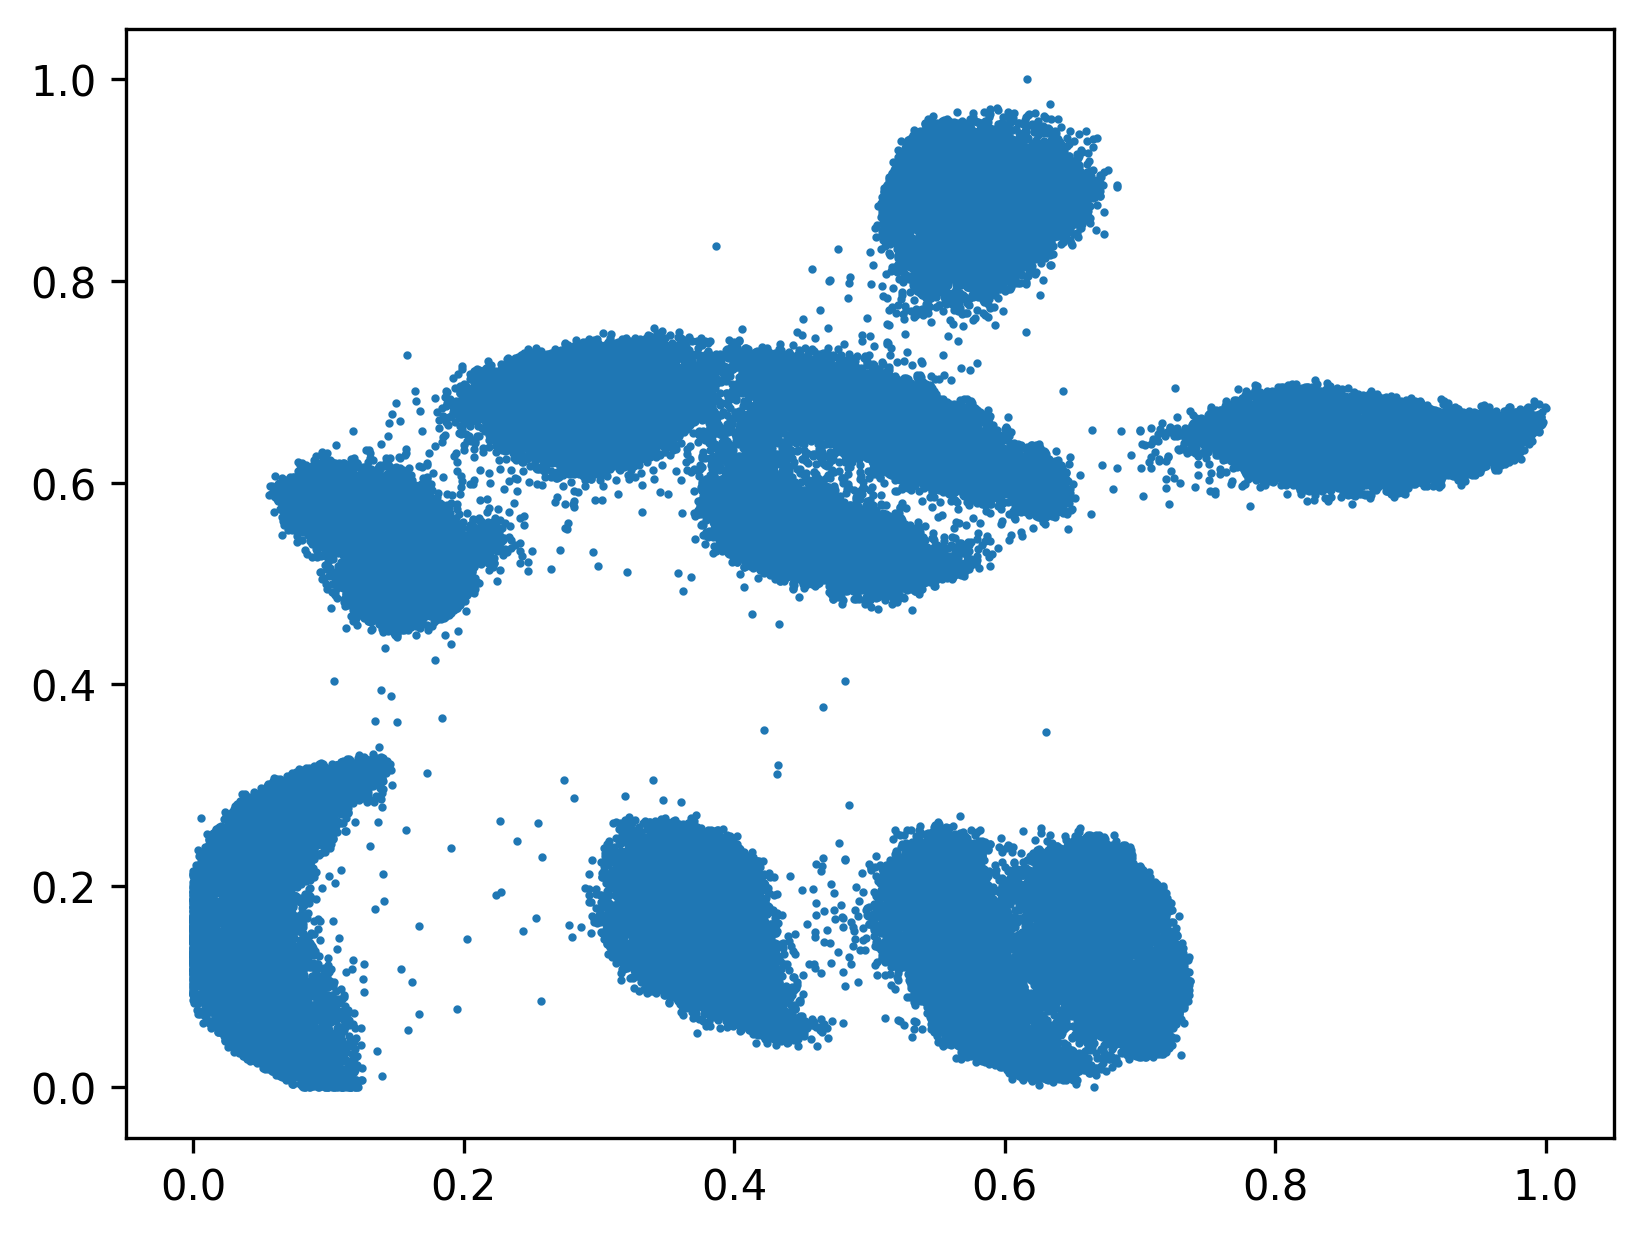

In [62]:
z_train = normalise(Z_train.detach().cpu())

plt.figure(dpi=300)
plt.scatter(z_train[:,0], z_train[:,1], s=1)
plt.show()

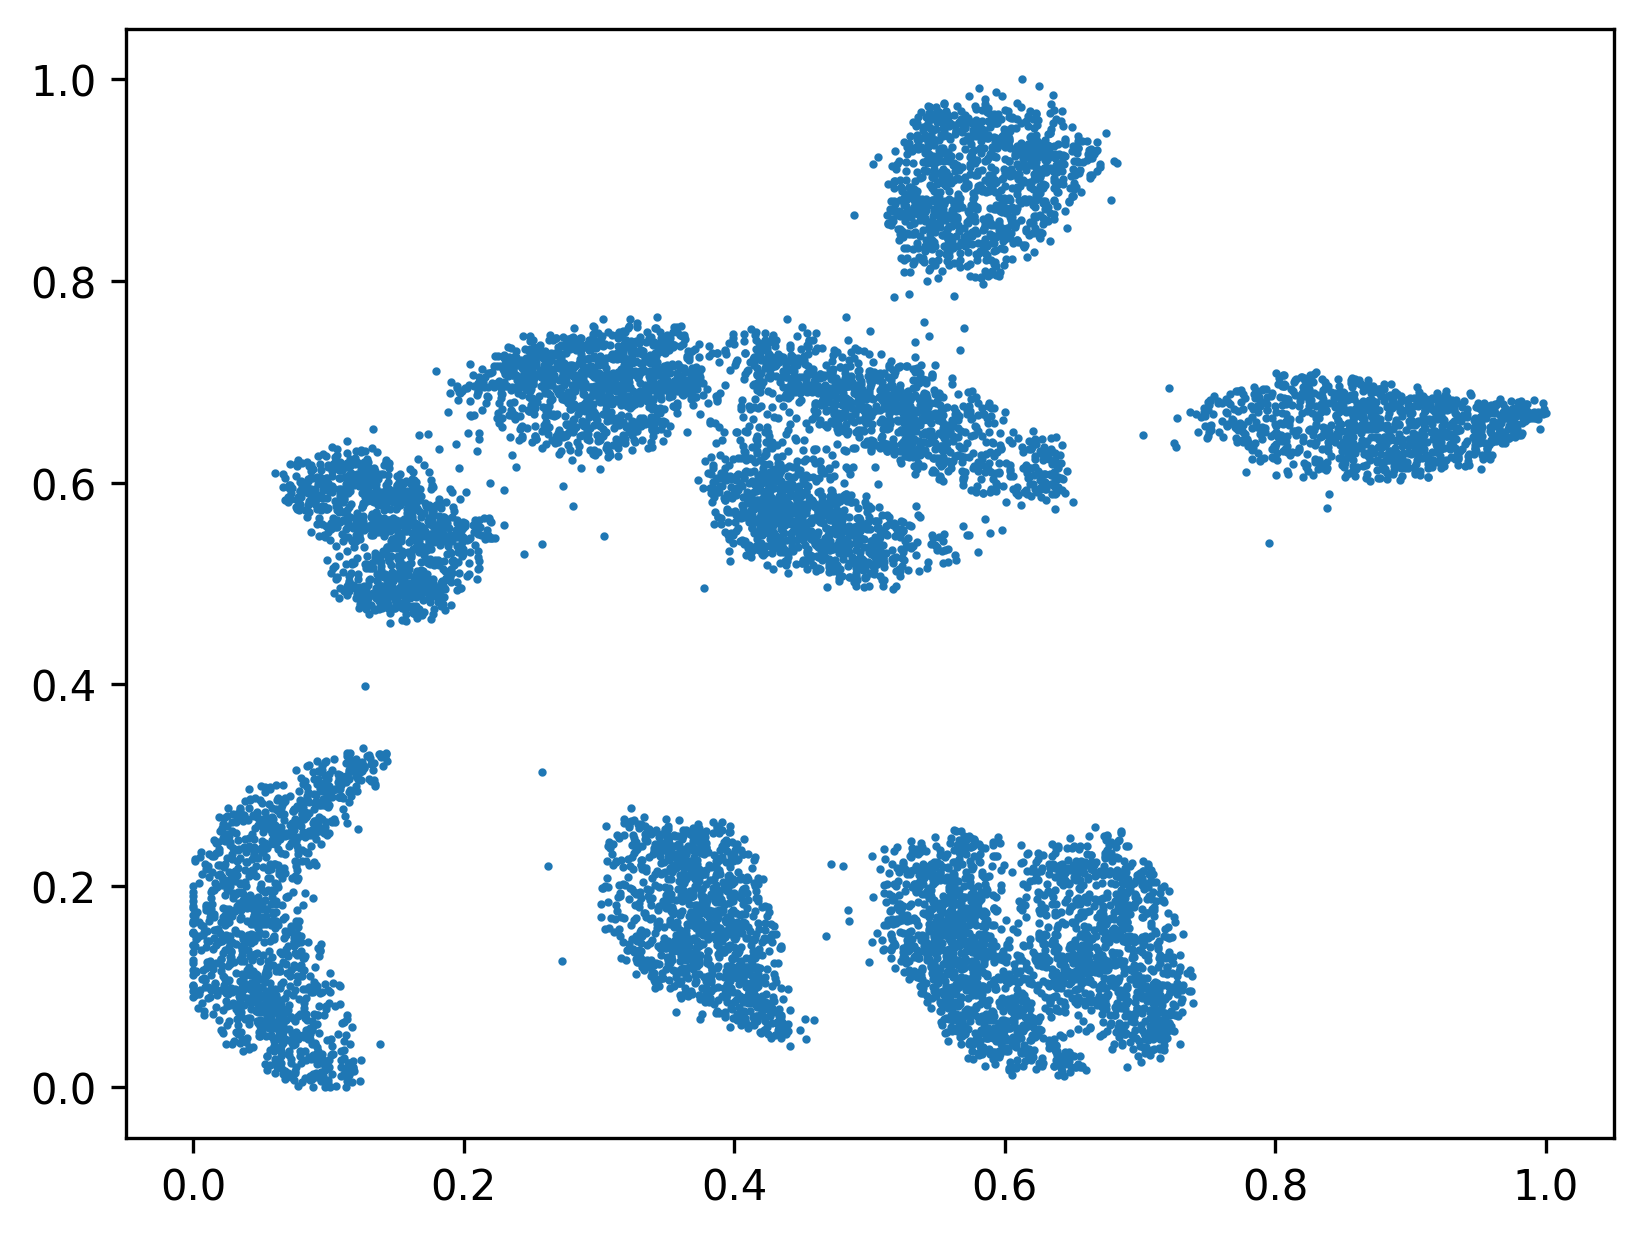

In [63]:
z_test = normalise(Z_test.detach().cpu())

plt.figure(dpi=300)
plt.scatter(z_test[:,0], z_test[:,1], s=1)
plt.show()

In [106]:
class Clf_MLP(nn.Module):
    def __init__(self, input_size=2, hidden=128):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden)
        self.linear2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        return x

model = Clf_MLP(input_size=2, hidden=100).cuda()
print(model)
print("num params: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Clf_MLP(
  (linear1): Linear(in_features=2, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)
num params: 1310


In [107]:
y_train_onehot = F.one_hot(y_train).float().cuda()
y_test_onehot = F.one_hot(y_test).float().cuda()

y_train_onehot.shape, y_test_onehot.shape

(torch.Size([60000, 10]), torch.Size([10000, 10]))

In [109]:
train_dataset_clf = torch.utils.data.TensorDataset(z_train, y_train_onehot)
train_loader_clf = torch.utils.data.DataLoader(train_dataset_clf, batch_size=100, shuffle=True)

test_dataset_clf = torch.utils.data.TensorDataset(z_test, y_test_onehot)
test_loader_clf = torch.utils.data.DataLoader(test_dataset_clf, batch_size=100, shuffle=False)

len(train_dataset_clf), len(test_dataset_clf)

(60000, 10000)

In [110]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

for epoch in range(20):

    # training

    train_loss = 0.
    
    for data, label in tqdm(train_loader_clf):
        
        optimizer.zero_grad()

        pred = model(data.cuda())
        
        loss = F.cross_entropy(pred, label) + 1e-3 * sum(p.pow(2).sum() for p in model.parameters())

        train_loss += loss.item() / len(train_loader_clf)
        
        loss.backward()
        
        optimizer.step()

    train_losses.append(train_loss)


    # testing

    model.eval()

    y_preds = []
    y_trues = []

    for data, label in tqdm(test_loader_clf):
        pred = model(data.cuda())

        y_pred = torch.argmax(pred.detach().cpu(), dim=1).numpy()
        y_true = torch.argmax(label.detach().cpu(), dim=1).numpy()

        y_preds.append(y_pred)
        y_trues.append(y_true)
        
    acc = sklearn.metrics.accuracy_score(y_true=np.hstack(y_trues), y_pred=np.hstack(y_preds))

    # y_pred = torch.argmax(pred.detach().cpu(), dim=1)
    # y_true = torch.argmax(label.detach().cpu(), dim=1)
    # acc = sklearn.metrics.accuracy_score(y_true=y_true, y_pred=y_pred)

    print('epoch: {}, train_loss: {}, test_acc: {}'.format(epoch, train_loss, acc))

100%|██████████| 100/100 [00:00<00:00, 613.40it/s]


epoch: 0, loss: 2.05384581565857, acc: 0.3861


100%|██████████| 100/100 [00:00<00:00, 609.76it/s]


epoch: 1, loss: 1.7682959075768796, acc: 0.4639


100%|██████████| 100/100 [00:00<00:00, 740.74it/s]


epoch: 2, loss: 1.7071110449234628, acc: 0.4694


100%|██████████| 100/100 [00:00<00:00, 689.66it/s]


epoch: 3, loss: 1.6895005754629755, acc: 0.466


100%|██████████| 100/100 [00:00<00:00, 854.71it/s]


epoch: 4, loss: 1.6818028245369576, acc: 0.4672


100%|██████████| 100/100 [00:00<00:00, 781.24it/s]


epoch: 5, loss: 1.6062412834167485, acc: 0.5684


100%|██████████| 100/100 [00:00<00:00, 699.30it/s]


epoch: 6, loss: 1.53332169433435, acc: 0.5682


100%|██████████| 100/100 [00:00<00:00, 740.71it/s]


epoch: 7, loss: 1.523384152054788, acc: 0.5687


100%|██████████| 100/100 [00:00<00:00, 636.95it/s]


epoch: 8, loss: 1.5198455770810457, acc: 0.5748


100%|██████████| 100/100 [00:00<00:00, 699.26it/s]


epoch: 9, loss: 1.1261855035026878, acc: 0.867


100%|██████████| 100/100 [00:00<00:00, 609.76it/s]


epoch: 10, loss: 0.7802687012155856, acc: 0.9526


100%|██████████| 100/100 [00:00<00:00, 588.23it/s]


epoch: 11, loss: 0.7093354052305211, acc: 0.9513


100%|██████████| 100/100 [00:00<00:00, 568.12it/s]


epoch: 12, loss: 0.7018436490496002, acc: 0.9532


100%|██████████| 100/100 [00:00<00:00, 800.01it/s]


epoch: 13, loss: 0.6978671756386751, acc: 0.9509


100%|██████████| 100/100 [00:00<00:00, 689.66it/s]


epoch: 14, loss: 0.6955394652485847, acc: 0.9529


100%|██████████| 100/100 [00:00<00:00, 806.44it/s]


epoch: 15, loss: 0.6941311077276867, acc: 0.9527


100%|██████████| 100/100 [00:00<00:00, 775.19it/s]


epoch: 16, loss: 0.6932176239291821, acc: 0.9534


100%|██████████| 100/100 [00:00<00:00, 653.54it/s]


epoch: 17, loss: 0.6924709421396256, acc: 0.9529


100%|██████████| 100/100 [00:00<00:00, 746.22it/s]


epoch: 18, loss: 0.691819240947565, acc: 0.9545


100%|██████████| 100/100 [00:00<00:00, 833.35it/s]

epoch: 19, loss: 0.6913364737232521, acc: 0.9538


In [111]:
model.eval()

y_preds = []
y_trues = []

for data, label in tqdm(train_loader_clf):
    pred = model(data.cuda())

    y_pred = torch.argmax(pred.detach().cpu(), dim=1).numpy()
    y_true = torch.argmax(label.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_trues.append(y_true)
    
acc = sklearn.metrics.accuracy_score(y_true=np.hstack(y_trues), y_pred=np.hstack(y_preds))
acc

100%|██████████| 600/600 [00:00<00:00, 772.20it/s]


0.9525

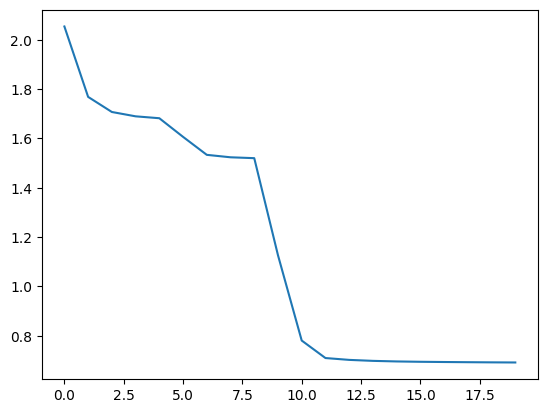

In [112]:
plt.plot(train_losses)

In [113]:
torch.save(model.state_dict(), "./data/MLP_clf.pt")

In [114]:
torch.save(train_losses, "./data/MLP_clf_train_losses.pt")

In [125]:
# model.load_state_dict(torch.load("./data/MLP_clf.pt"))
model.load_state_dict(torch.load("./results/231203164939/II-1/HM_weights_II-1.pt"))
model.eval()

Clf_MLP(
  (linear1): Linear(in_features=2, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [80]:
import seaborn as sns
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [81]:
sns.color_palette("hls", 10)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6207999999999999)]

In [82]:
sns.color_palette("Paired", 10)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

In [83]:
sns.color_palette("deep", 10)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

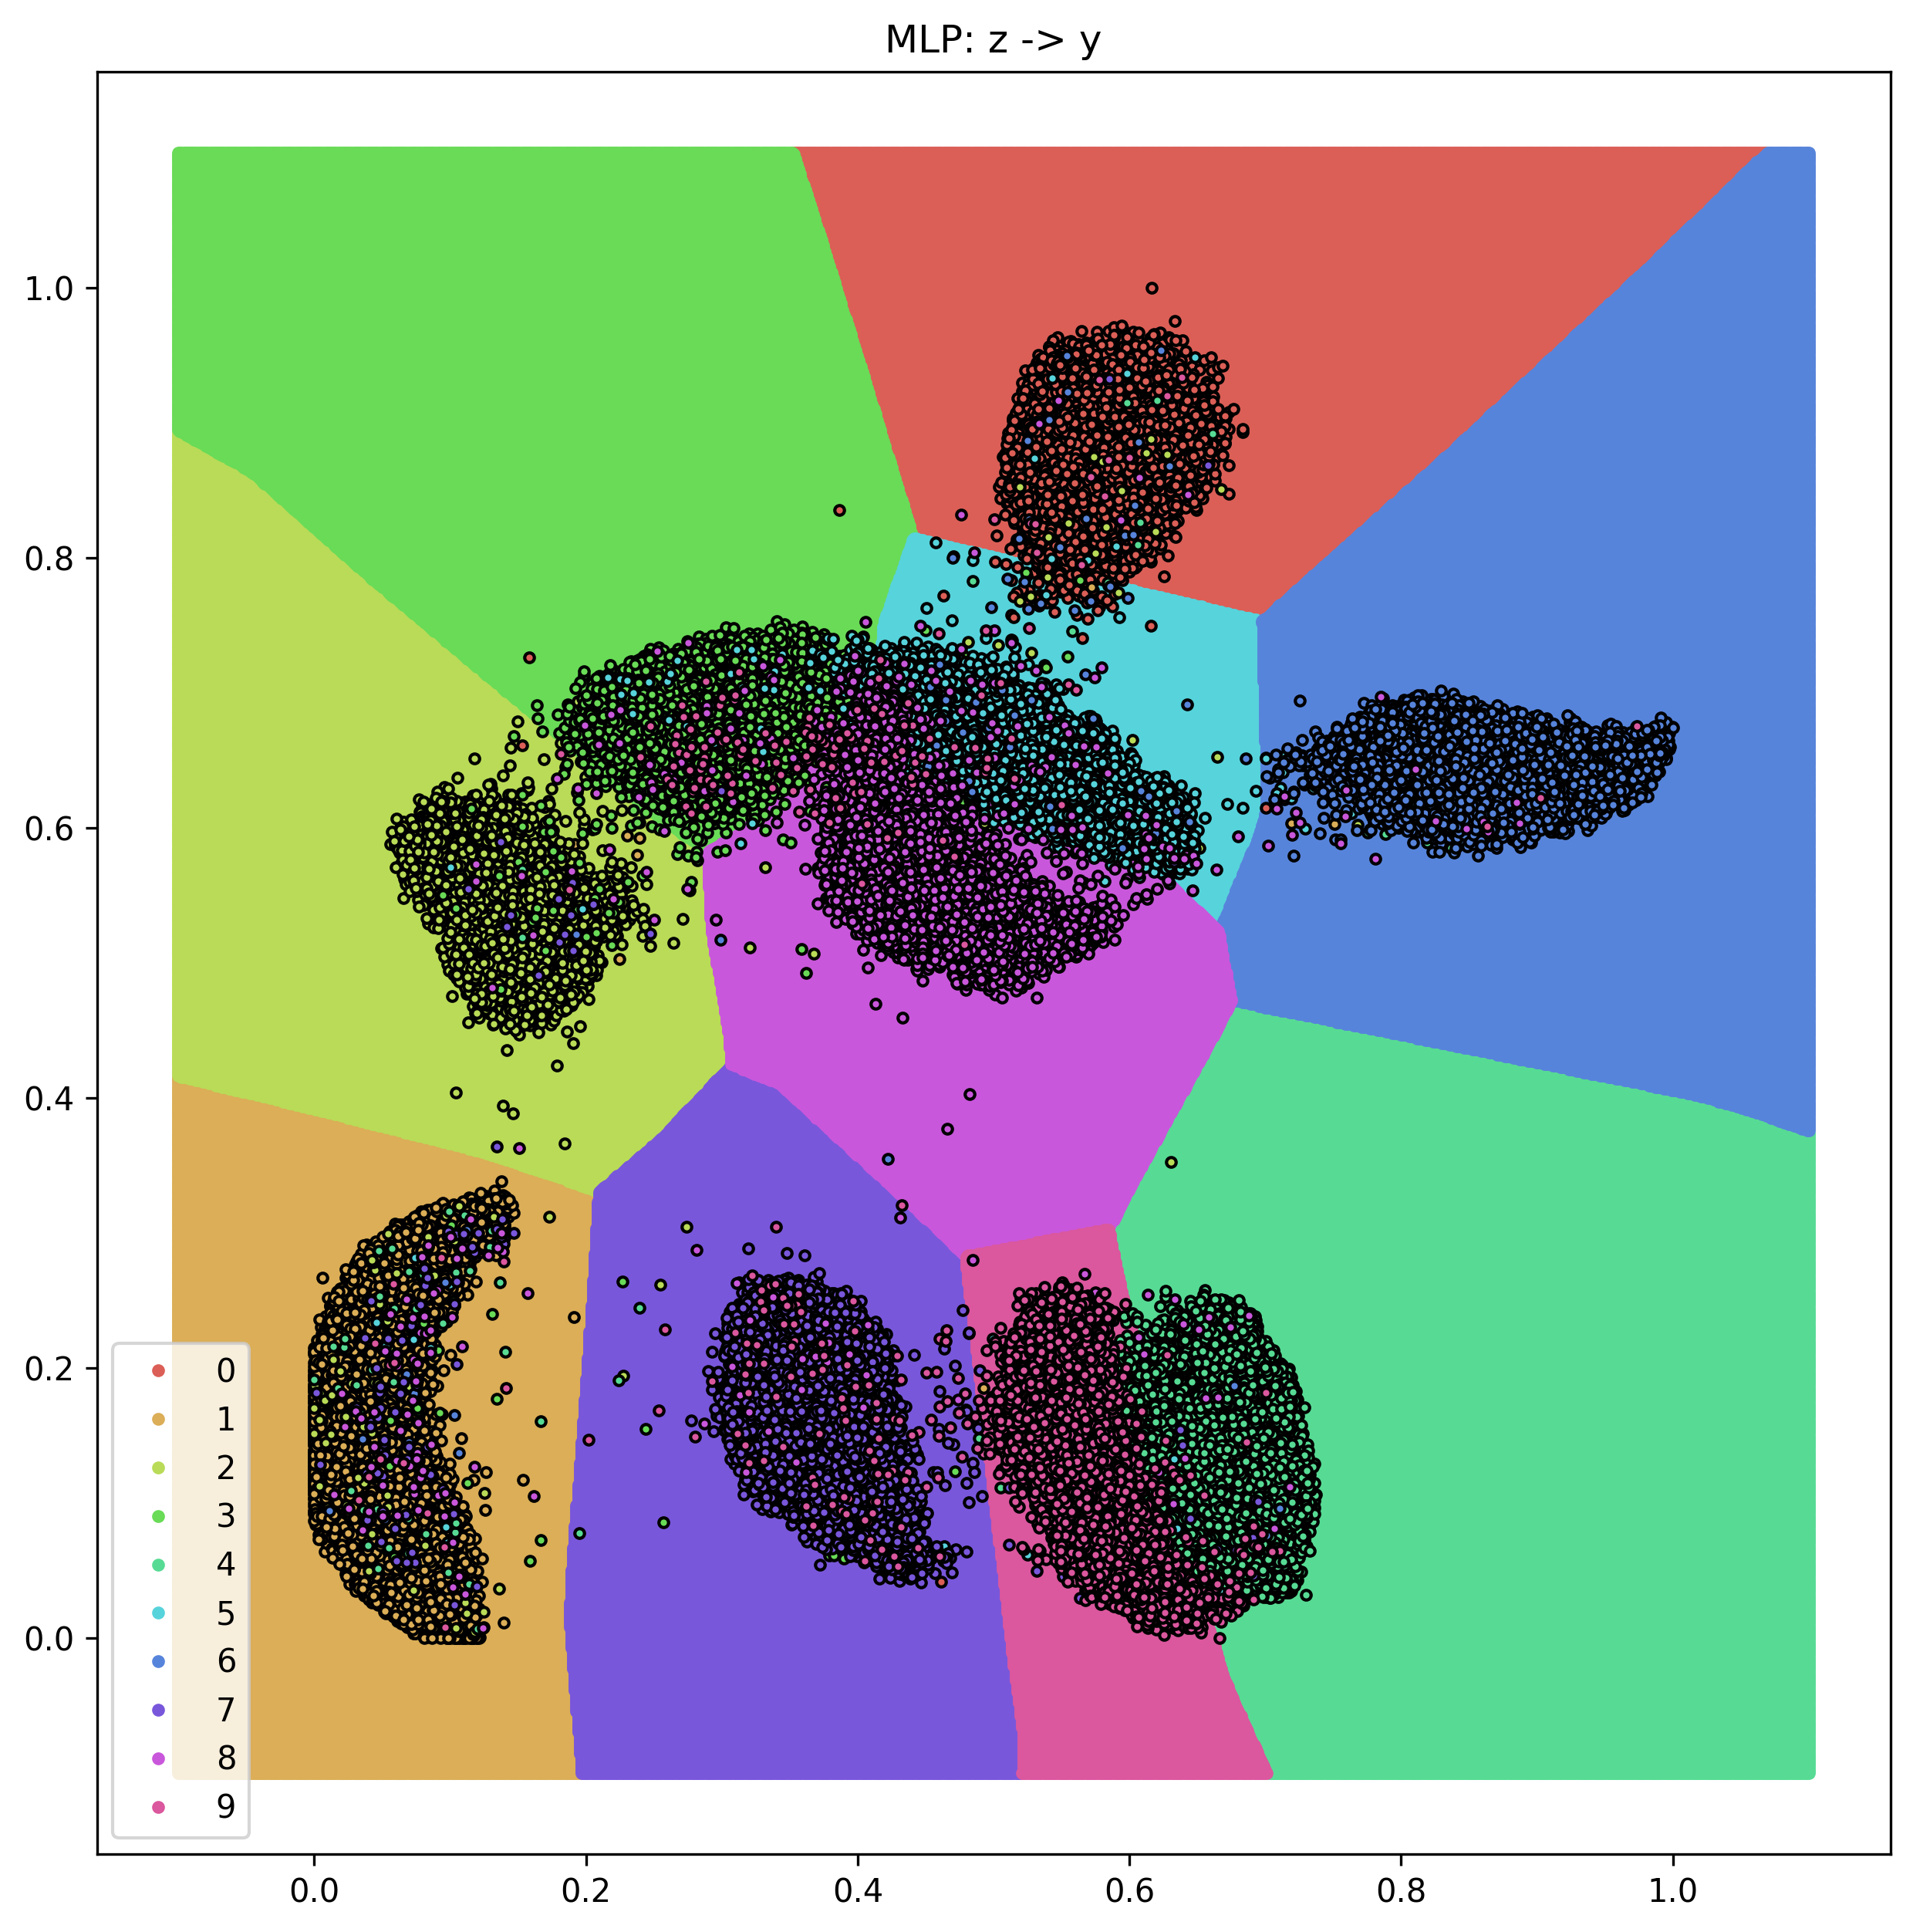

In [126]:
num_classes = 10

def getGrid(n=1000, rim=0.1):
    """generate quadratic gridover unit square plus rim"""
    nx, ny= (n, n)
    x = np.linspace(-rim, 1+rim, nx)
    y = np.linspace(-rim, 1+rim, ny)
    xv,yv = np.meshgrid(x, y)
    return np.array([a for a in zip(xv.flat, yv.flat)])

G = getGrid()

model.eval()
pred = model(torch.from_numpy(G).float().cuda())
pred = torch.argmax(pred, axis=1).detach().cpu().numpy()

# plot prediction and training data
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
for i in range(num_classes):
    s = G[pred==i]
    ax.plot(s[:,0], s[:,1], ".", ms=6, color=sns.color_palette("hls", 10)[i])
plt.gca().set_prop_cycle(None)

for i in range(num_classes):
# for i in [4]:
    s = z_train[y_train==i]
    ax.plot(s[:,0], s[:,1], "o", ms=3, markeredgecolor='black', markeredgewidth=1, color=sns.color_palette("hls", 10)[i])

# for i in range(num_classes):
#     s = z_test[y_test==i]
#     ax.plot(s[:,0], s[:,1], "o", ms=3, markeredgecolor='black', markeredgewidth=1)

plt.title("MLP: z -> y")
plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
plt.show()

# interactive labelling

In [4]:
z_train = normalise(torch.load("./data/Z_train_pretrainDR_60k.pt"))
z_train.shape

torch.Size([60000, 2])

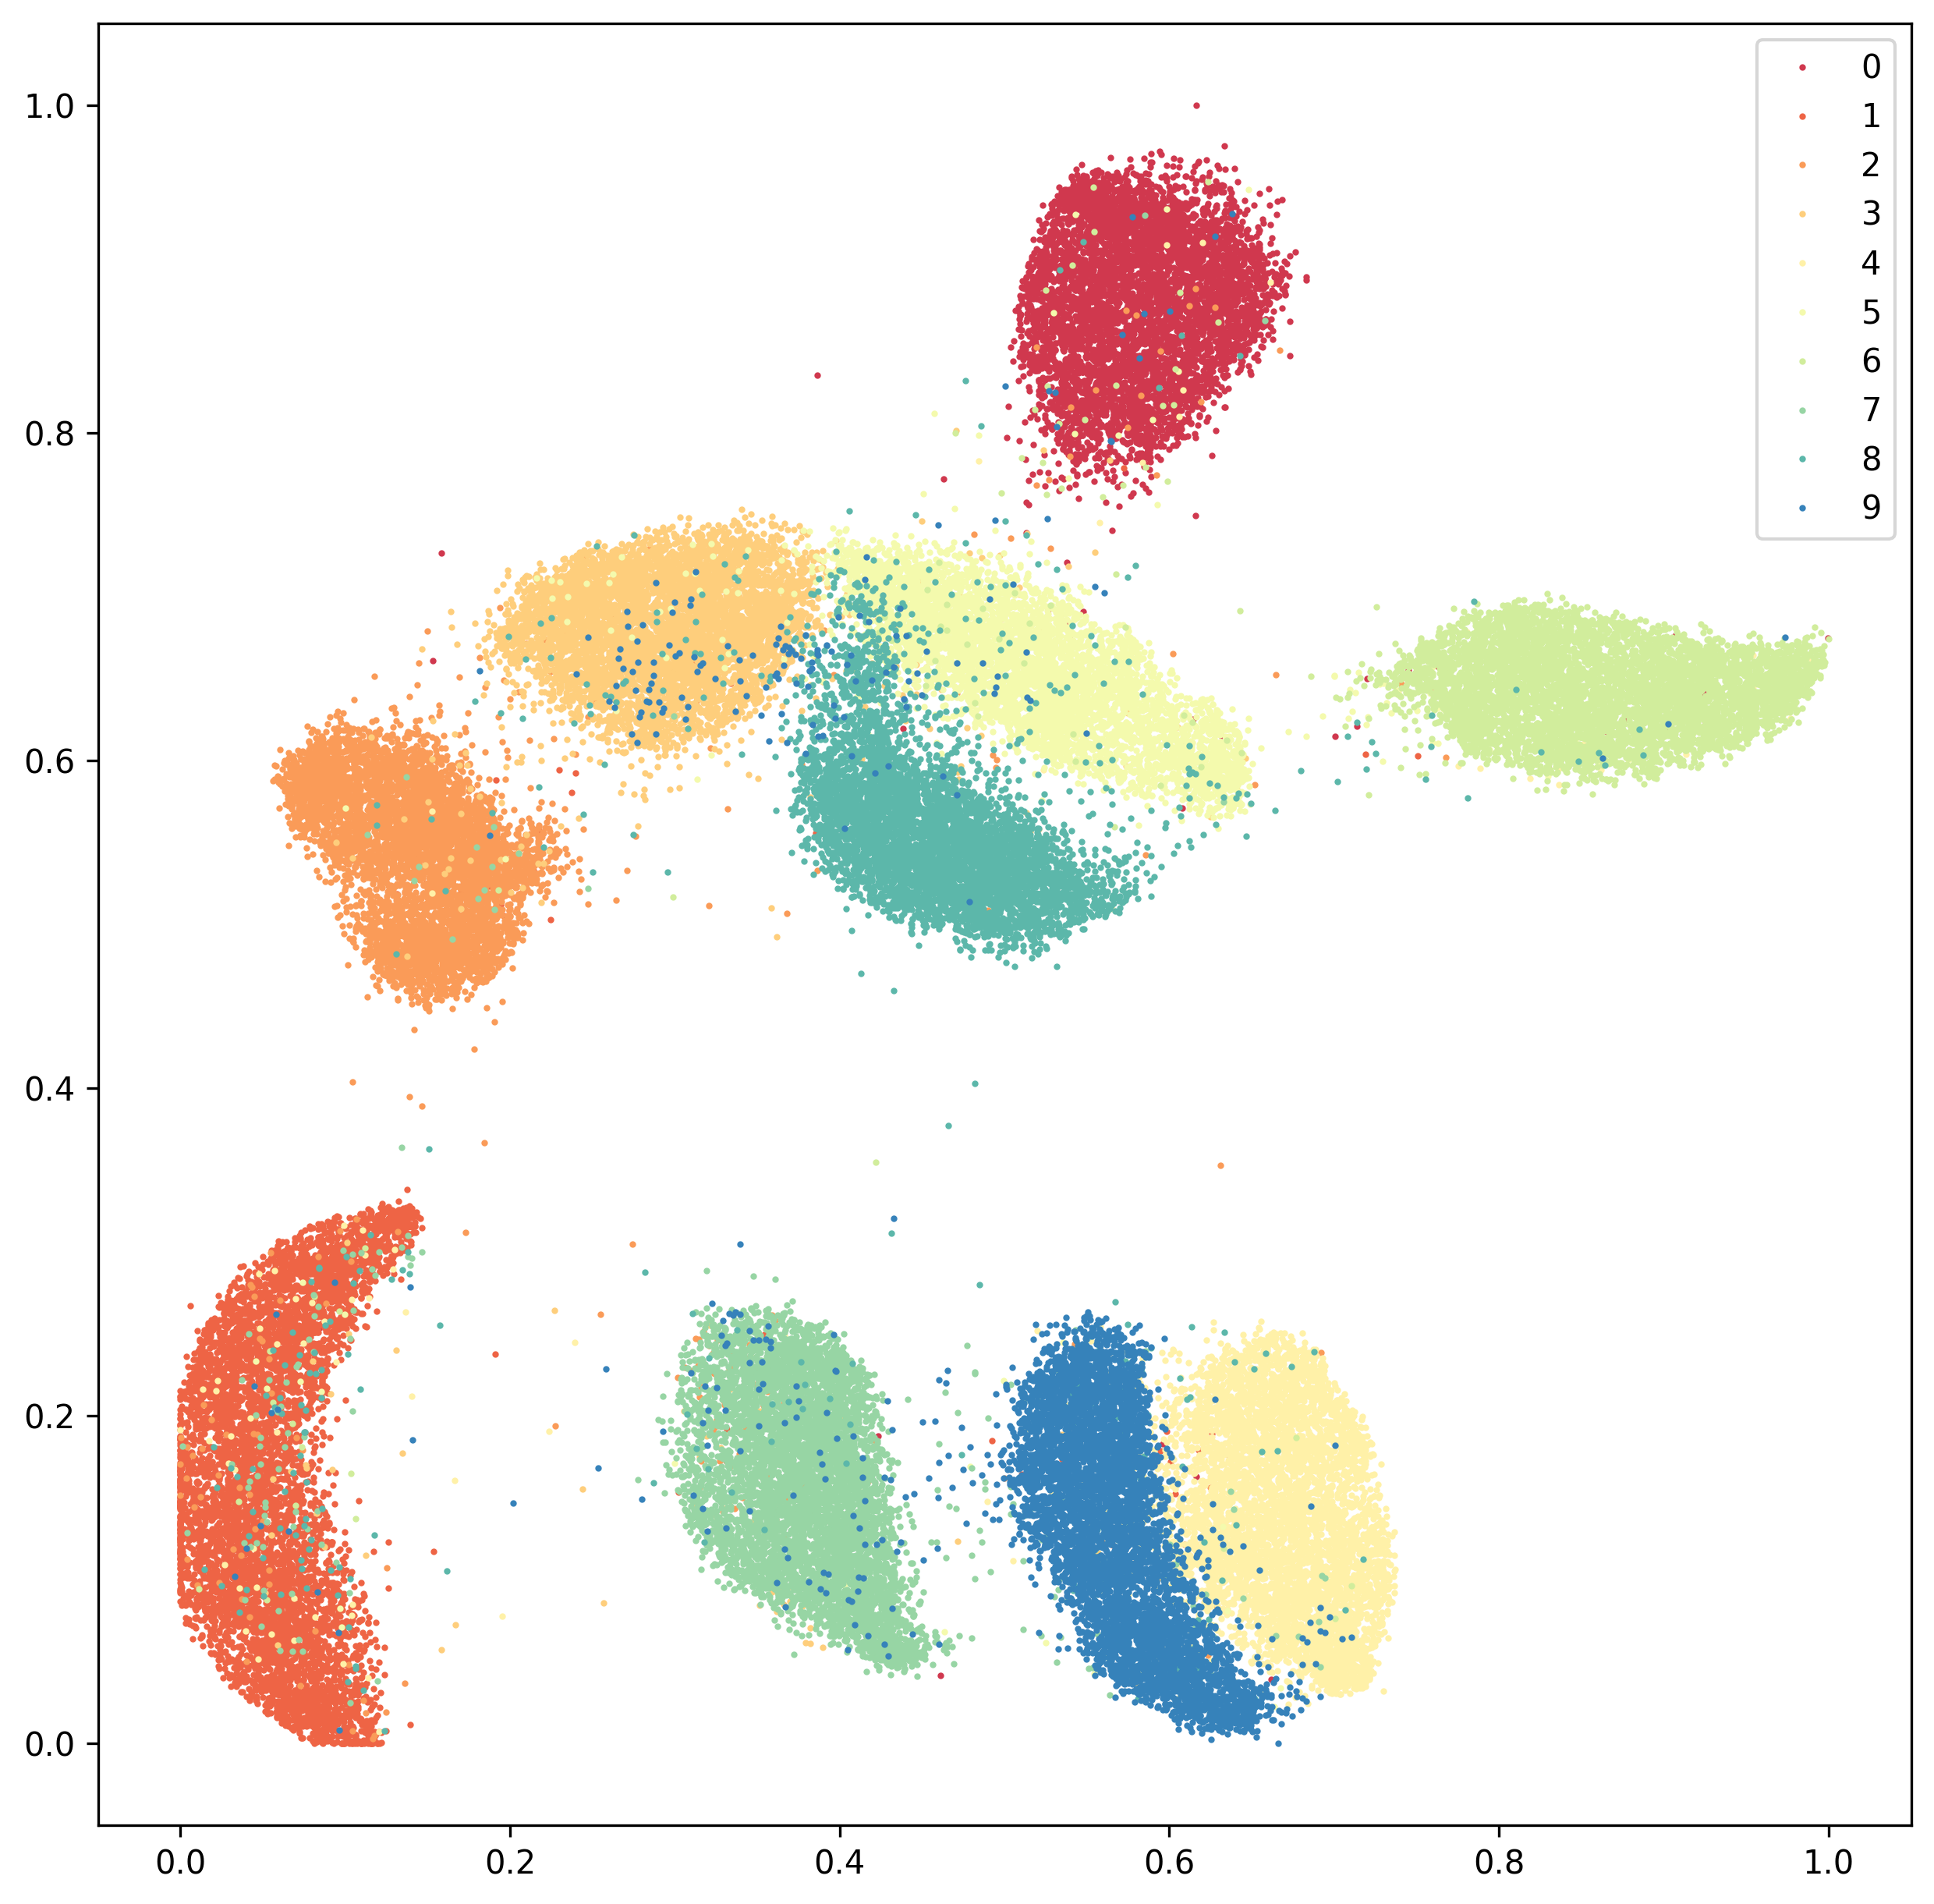

In [5]:
# sn.color_palette("hls", 10)
# plt.figure(dpi=300)
# plt.scatter(z_train[:,0], z_train[:,1], s=1, c=y_train)
# plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
# plt.show()

# plot prediction and training data
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

for i in range(10):
    s = z_train[y_train==i]
    ax.plot(s[:,0], s[:,1], "o", ms=1, color=sn.color_palette("Spectral", 10)[i])

plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
plt.show()

In [6]:
import pickle
clusters = pickle.load(open("./clusters.pkl", "rb"))
clusters.keys()

dict_keys(['clusters_1', 'clusters_2', 'clusters_3', 'clusters_4', 'clusters_5', 'clusters_6', 'clusters_7', 'clusters_8', 'clusters_9', 'clusters_10'])

In [28]:
# plot prediction and training data
fig, ax = plt.subplots(figsize=(10, 10), dpi=1500)

data = []
labels = [1, 7, 9, 4, 2, 3, 8, 5, 0, 6]
for i in range(10):
    s = clusters["clusters_{}".format(labels.index(i)+1)]
    ax.plot(s[:,0], s[:,1], "o", ms=1, color=sn.color_palette("Spectral", 10)[i])

    data.append(torch.hstack([torch.from_numpy(s), torch.ones(s.shape[0],1)*i]))
data = torch.vstack(data)
print(data.shape)

plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
plt.show()

torch.save(data, "./results/231204144400/data1.pt")

torch.Size([59706, 3])


In [52]:
dataset_path = "./results/231204144400/data1.pt"

data = torch.load(dataset_path)
data = data[torch.randperm(data.shape[0])]
X_train, y_trian = data[:50000, :2], data[:50000, 2]
X_test, y_test = data[50000:, :2], data[50000:, 2]

In [53]:
data[:3]

tensor([[0.4579, 0.6259, 5.0000],
        [0.1098, 0.5112, 2.0000],
        [0.5780, 0.1746, 9.0000]], dtype=torch.float64)